# 训练你的物体检测器

In [ ]:
!pip install gluoncv

In [1]:
import gluoncv as gcv
import mxnet as mx

# 准备训练集

In [2]:
import os

class DetectionDataset(gcv.data.VOCDetection):
    CLASSES = ['cocacola', 'noodles', 'hand', 'fake']  # Yolo3 need at least 4 classes (https://github.com/apache/incubator-mxnet/pull/17689/files)
    def __init__(self, root):
        self._im_shapes = {}
        self._root = os.path.expanduser(root)
        self._transform = None
        self._items = [(self._root, x.strip('.jpg')) for x in os.listdir(self._root) if x.endswith('.jpg')]
        self._anno_path = os.path.join('{}', '{}.xml')
        self._image_path = os.path.join('{}', '{}.jpg')
        self.index_map = dict(zip(self.classes, range(self.num_class)))
        self._label_cache = self._preload_labels()
        
    def __str__(self):
        detail = self._root
        return self.__class__.__name__ + '(' + detail + ')'
    
    @property
    def classes(self):
        return self.CLASSES
    
    @property
    def num_class(self):
        return len(self.classes)
        
train_dataset = DetectionDataset('../images/shenzhen_v1')
print('class_names:', train_dataset.classes)
print('num_images:', len(train_dataset))

class_names: ['cocacola', 'noodles', 'hand', 'fake']
num_images: 149


# 可视化数据

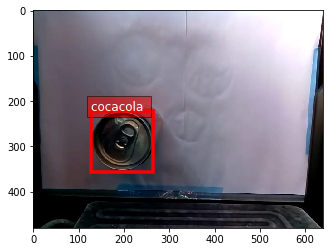

In [3]:
from matplotlib import pyplot as plt
from gluoncv.utils import viz

sample = train_dataset[0]
train_image = sample[0]
train_label = sample[1]

ax = viz.plot_bbox(
    train_image.asnumpy(),
    train_label[:, :4],
    labels=train_label[:, 4:5],
    class_names=train_dataset.classes)
plt.show()

# for i in range(len(train_dataset)):
#     sample = train_dataset[i]
#     train_image = sample[0]
#     train_label = sample[1]

#     ax = viz.plot_bbox(
#         train_image.asnumpy(),
#         train_label[:, :4],
#         labels=train_label[:, 4:5],
#         class_names=train_dataset.classes)
#     plt.show()


# 定义训练过程

In [4]:
import time
from datetime import datetime
from mxnet import autograd
from gluoncv.data.batchify import Tuple, Stack, Pad

def train_model(train_dataset, epochs=50):
    ctx = mx.gpu(0)
#     ctx = mx.cpu(0)
    net = gcv.model_zoo.get_model('yolo3_darknet53_custom', classes=train_dataset.classes, transfer='coco')
    #net.load_parameters('object_detector_epoch100_10_23_2019_21_59_13.params')  # TODO continue training
    net.collect_params().reset_ctx(ctx)
    width, height = 512, 512  # suppose we use 512 as base training size
    gcv.utils.random.seed(233)
    
    batch_size = 16  # 16 for p3.2xlarge, 8 for p2.2xlarge
    # you can make it larger(if your CPU has more cores) to accelerate data loading
    num_workers = 4

    train_transform = gcv.data.transforms.presets.yolo.YOLO3DefaultTrainTransform(width, height, net)
    batchify_fn = Tuple(*([Stack() for _ in range(6)] + [Pad(axis=0, pad_val=-1) for _ in range(1)]))
    train_loader = mx.gluon.data.DataLoader(
        train_dataset.transform(train_transform),
        batch_size,
        shuffle=True,
        batchify_fn=batchify_fn,
        last_batch='rollover',
        num_workers=num_workers)
    
    sigmoid_ce = mx.gluon.loss.SigmoidBinaryCrossEntropyLoss(from_sigmoid=False)
    l1_loss = mx.gluon.loss.L1Loss()
    obj_metrics = mx.metric.Loss('ObjLoss')
    center_metrics = mx.metric.Loss('BoxCenterLoss')
    scale_metrics = mx.metric.Loss('BoxScaleLoss')
    cls_metrics = mx.metric.Loss('ClassLoss')
    for k, v in net.collect_params().items():
        if 'yolodetectionblock' not in k and 'yolooutput' not in k:
            # freeze upper layers
            v.grad_req = 'null'
    trainer = mx.gluon.Trainer(
        net.collect_params(), 'sgd',
        {'learning_rate': 0.0005, 'wd': 0.0005, 'momentum': 0.9})  # 'learning_rate': 0.001
    
    net.hybridize(static_alloc=True, static_shape=True)
    
    for epoch in range(epochs):
        tic = time.time()
        btic = time.time()
        
        for i, batch in enumerate(train_loader):
            batch_size = batch[0].shape[0]
            data = mx.gluon.utils.split_and_load(batch[0], ctx_list=[ctx], batch_axis=0)
            # objectness, center_targets, scale_targets, weights, class_targets
            fixed_targets = [mx.gluon.utils.split_and_load(batch[it], ctx_list=[ctx], batch_axis=0) for it in range(1, 6)]
            gt_boxes = mx.gluon.utils.split_and_load(batch[6], ctx_list=[ctx], batch_axis=0)
            sum_losses = []
            obj_losses = []
            center_losses = []
            scale_losses = []
            cls_losses = []
            
            with autograd.record():
                for ix, x in enumerate(data):
                    obj_loss, center_loss, scale_loss, cls_loss = net(x, gt_boxes[ix], *[ft[ix] for ft in fixed_targets])
                    sum_losses.append(obj_loss + center_loss + scale_loss + cls_loss)
                    obj_losses.append(obj_loss)
                    center_losses.append(center_loss)
                    scale_losses.append(scale_loss)
                    cls_losses.append(cls_loss)
                autograd.backward(sum_losses)
            trainer.step(batch_size)
            obj_metrics.update(0, obj_losses)
            center_metrics.update(0, center_losses)
            scale_metrics.update(0, scale_losses)
            cls_metrics.update(0, cls_losses)
            name1, loss1 = obj_metrics.get()
            name2, loss2 = center_metrics.get()
            name3, loss3 = scale_metrics.get()
            name4, loss4 = cls_metrics.get()
            print('[Epoch {}][Batch {}], LR: {:.2E}, Speed: {:.3f} samples/sec, {}={:.3f}, {}={:.3f}, {}={:.3f}, {}={:.3f}'.format(
                epoch, i, trainer.learning_rate, batch_size/(time.time()-btic), name1, loss1, name2, loss2, name3, loss3, name4, loss4))
            btic = time.time()
    return net
        


# 开始训练

In [5]:
epochs = 200
net = train_model(train_dataset, epochs=epochs)
save_file = 'object_detector_epoch{}_{}.params'.format(epochs, datetime.now().strftime("%m_%d_%Y_%H_%M_%S"))
net.save_parameters(save_file)
print('Saved model to disk: ' + save_file)

checkpoint1
checkpoint1.5
checkpoint2
checkpoint3
[Epoch 0][Batch 0], LR: 5.00E-04, Speed: 1.913 samples/sec, ObjLoss=11899.553, BoxCenterLoss=7.139, BoxScaleLoss=4.134, ClassLoss=7.703
[Epoch 0][Batch 1], LR: 5.00E-04, Speed: 98.721 samples/sec, ObjLoss=5992.023, BoxCenterLoss=7.488, BoxScaleLoss=4.757, ClassLoss=7.759
[Epoch 0][Batch 2], LR: 5.00E-04, Speed: 105.435 samples/sec, ObjLoss=4005.710, BoxCenterLoss=7.058, BoxScaleLoss=4.236, ClassLoss=7.388
[Epoch 0][Batch 3], LR: 5.00E-04, Speed: 105.546 samples/sec, ObjLoss=3012.568, BoxCenterLoss=6.673, BoxScaleLoss=3.991, ClassLoss=6.866
[Epoch 0][Batch 4], LR: 5.00E-04, Speed: 105.477 samples/sec, ObjLoss=2419.869, BoxCenterLoss=6.772, BoxScaleLoss=3.830, ClassLoss=6.965
[Epoch 0][Batch 5], LR: 5.00E-04, Speed: 105.363 samples/sec, ObjLoss=2026.202, BoxCenterLoss=6.765, BoxScaleLoss=3.706, ClassLoss=6.905
[Epoch 0][Batch 6], LR: 5.00E-04, Speed: 105.178 samples/sec, ObjLoss=1740.376, BoxCenterLoss=6.681, BoxScaleLoss=3.524, ClassLoss

[Epoch 6][Batch 6], LR: 5.00E-04, Speed: 100.863 samples/sec, ObjLoss=208.087, BoxCenterLoss=6.183, BoxScaleLoss=1.697, ClassLoss=4.572
[Epoch 6][Batch 7], LR: 5.00E-04, Speed: 99.490 samples/sec, ObjLoss=205.014, BoxCenterLoss=6.157, BoxScaleLoss=1.687, ClassLoss=4.545
[Epoch 6][Batch 8], LR: 5.00E-04, Speed: 20.348 samples/sec, ObjLoss=202.427, BoxCenterLoss=6.157, BoxScaleLoss=1.687, ClassLoss=4.533
[Epoch 6][Batch 9], LR: 5.00E-04, Speed: 96.575 samples/sec, ObjLoss=199.387, BoxCenterLoss=6.145, BoxScaleLoss=1.680, ClassLoss=4.513
[Epoch 7][Batch 0], LR: 5.00E-04, Speed: 8.224 samples/sec, ObjLoss=196.563, BoxCenterLoss=6.140, BoxScaleLoss=1.674, ClassLoss=4.497
[Epoch 7][Batch 1], LR: 5.00E-04, Speed: 29.832 samples/sec, ObjLoss=193.828, BoxCenterLoss=6.147, BoxScaleLoss=1.671, ClassLoss=4.486
[Epoch 7][Batch 2], LR: 5.00E-04, Speed: 97.233 samples/sec, ObjLoss=191.037, BoxCenterLoss=6.118, BoxScaleLoss=1.662, ClassLoss=4.453
[Epoch 7][Batch 3], LR: 5.00E-04, Speed: 99.299 samples

[Epoch 13][Batch 2], LR: 5.00E-04, Speed: 100.878 samples/sec, ObjLoss=107.818, BoxCenterLoss=5.871, BoxScaleLoss=1.560, ClassLoss=3.644
[Epoch 13][Batch 3], LR: 5.00E-04, Speed: 98.564 samples/sec, ObjLoss=107.003, BoxCenterLoss=5.868, BoxScaleLoss=1.556, ClassLoss=3.636
[Epoch 13][Batch 4], LR: 5.00E-04, Speed: 15.976 samples/sec, ObjLoss=106.197, BoxCenterLoss=5.870, BoxScaleLoss=1.554, ClassLoss=3.629
[Epoch 13][Batch 5], LR: 5.00E-04, Speed: 99.593 samples/sec, ObjLoss=105.383, BoxCenterLoss=5.867, BoxScaleLoss=1.551, ClassLoss=3.621
[Epoch 13][Batch 6], LR: 5.00E-04, Speed: 104.179 samples/sec, ObjLoss=104.591, BoxCenterLoss=5.868, BoxScaleLoss=1.548, ClassLoss=3.611
[Epoch 13][Batch 7], LR: 5.00E-04, Speed: 103.408 samples/sec, ObjLoss=103.815, BoxCenterLoss=5.862, BoxScaleLoss=1.543, ClassLoss=3.599
[Epoch 13][Batch 8], LR: 5.00E-04, Speed: 18.026 samples/sec, ObjLoss=103.095, BoxCenterLoss=5.865, BoxScaleLoss=1.540, ClassLoss=3.590
[Epoch 14][Batch 0], LR: 5.00E-04, Speed: 7.5

[Epoch 19][Batch 9], LR: 5.00E-04, Speed: 104.073 samples/sec, ObjLoss=73.372, BoxCenterLoss=5.776, BoxScaleLoss=1.434, ClassLoss=3.155
[Epoch 20][Batch 0], LR: 5.00E-04, Speed: 9.580 samples/sec, ObjLoss=73.001, BoxCenterLoss=5.774, BoxScaleLoss=1.432, ClassLoss=3.149
[Epoch 20][Batch 1], LR: 5.00E-04, Speed: 63.002 samples/sec, ObjLoss=72.634, BoxCenterLoss=5.772, BoxScaleLoss=1.430, ClassLoss=3.145
[Epoch 20][Batch 2], LR: 5.00E-04, Speed: 24.083 samples/sec, ObjLoss=72.292, BoxCenterLoss=5.778, BoxScaleLoss=1.429, ClassLoss=3.147
[Epoch 20][Batch 3], LR: 5.00E-04, Speed: 94.223 samples/sec, ObjLoss=71.932, BoxCenterLoss=5.781, BoxScaleLoss=1.429, ClassLoss=3.145
[Epoch 20][Batch 4], LR: 5.00E-04, Speed: 20.673 samples/sec, ObjLoss=71.581, BoxCenterLoss=5.779, BoxScaleLoss=1.426, ClassLoss=3.137
[Epoch 20][Batch 5], LR: 5.00E-04, Speed: 81.144 samples/sec, ObjLoss=71.243, BoxCenterLoss=5.779, BoxScaleLoss=1.426, ClassLoss=3.129
[Epoch 20][Batch 6], LR: 5.00E-04, Speed: 21.239 sample

[Epoch 26][Batch 4], LR: 5.00E-04, Speed: 15.745 samples/sec, ObjLoss=56.247, BoxCenterLoss=5.721, BoxScaleLoss=1.355, ClassLoss=2.849
[Epoch 26][Batch 5], LR: 5.00E-04, Speed: 100.542 samples/sec, ObjLoss=56.030, BoxCenterLoss=5.719, BoxScaleLoss=1.355, ClassLoss=2.841
[Epoch 26][Batch 6], LR: 5.00E-04, Speed: 104.276 samples/sec, ObjLoss=55.833, BoxCenterLoss=5.721, BoxScaleLoss=1.355, ClassLoss=2.839
[Epoch 26][Batch 7], LR: 5.00E-04, Speed: 104.483 samples/sec, ObjLoss=55.617, BoxCenterLoss=5.722, BoxScaleLoss=1.354, ClassLoss=2.832
[Epoch 26][Batch 8], LR: 5.00E-04, Speed: 12.774 samples/sec, ObjLoss=55.416, BoxCenterLoss=5.717, BoxScaleLoss=1.353, ClassLoss=2.827
[Epoch 27][Batch 0], LR: 5.00E-04, Speed: 6.621 samples/sec, ObjLoss=55.208, BoxCenterLoss=5.717, BoxScaleLoss=1.353, ClassLoss=2.823
[Epoch 27][Batch 1], LR: 5.00E-04, Speed: 100.399 samples/sec, ObjLoss=55.002, BoxCenterLoss=5.716, BoxScaleLoss=1.353, ClassLoss=2.818
[Epoch 27][Batch 2], LR: 5.00E-04, Speed: 98.331 sam

[Epoch 33][Batch 0], LR: 5.00E-04, Speed: 9.841 samples/sec, ObjLoss=46.048, BoxCenterLoss=5.667, BoxScaleLoss=1.314, ClassLoss=2.588
[Epoch 33][Batch 1], LR: 5.00E-04, Speed: 82.569 samples/sec, ObjLoss=45.921, BoxCenterLoss=5.668, BoxScaleLoss=1.314, ClassLoss=2.585
[Epoch 33][Batch 2], LR: 5.00E-04, Speed: 39.181 samples/sec, ObjLoss=45.794, BoxCenterLoss=5.669, BoxScaleLoss=1.314, ClassLoss=2.581
[Epoch 33][Batch 3], LR: 5.00E-04, Speed: 100.329 samples/sec, ObjLoss=45.653, BoxCenterLoss=5.669, BoxScaleLoss=1.314, ClassLoss=2.578
[Epoch 33][Batch 4], LR: 5.00E-04, Speed: 13.136 samples/sec, ObjLoss=45.513, BoxCenterLoss=5.671, BoxScaleLoss=1.315, ClassLoss=2.575
[Epoch 33][Batch 5], LR: 5.00E-04, Speed: 102.849 samples/sec, ObjLoss=45.376, BoxCenterLoss=5.668, BoxScaleLoss=1.314, ClassLoss=2.571
[Epoch 33][Batch 6], LR: 5.00E-04, Speed: 103.213 samples/sec, ObjLoss=45.236, BoxCenterLoss=5.664, BoxScaleLoss=1.313, ClassLoss=2.564
[Epoch 33][Batch 7], LR: 5.00E-04, Speed: 54.742 samp

[Epoch 39][Batch 6], LR: 5.00E-04, Speed: 37.651 samples/sec, ObjLoss=39.032, BoxCenterLoss=5.607, BoxScaleLoss=1.273, ClassLoss=2.362
[Epoch 39][Batch 7], LR: 5.00E-04, Speed: 30.434 samples/sec, ObjLoss=38.935, BoxCenterLoss=5.608, BoxScaleLoss=1.273, ClassLoss=2.358
[Epoch 39][Batch 8], LR: 5.00E-04, Speed: 38.082 samples/sec, ObjLoss=38.832, BoxCenterLoss=5.605, BoxScaleLoss=1.272, ClassLoss=2.354
[Epoch 40][Batch 0], LR: 5.00E-04, Speed: 9.339 samples/sec, ObjLoss=38.731, BoxCenterLoss=5.604, BoxScaleLoss=1.271, ClassLoss=2.350
[Epoch 40][Batch 1], LR: 5.00E-04, Speed: 97.795 samples/sec, ObjLoss=38.633, BoxCenterLoss=5.601, BoxScaleLoss=1.270, ClassLoss=2.346
[Epoch 40][Batch 2], LR: 5.00E-04, Speed: 94.152 samples/sec, ObjLoss=38.540, BoxCenterLoss=5.601, BoxScaleLoss=1.269, ClassLoss=2.343
[Epoch 40][Batch 3], LR: 5.00E-04, Speed: 99.109 samples/sec, ObjLoss=38.455, BoxCenterLoss=5.603, BoxScaleLoss=1.269, ClassLoss=2.341
[Epoch 40][Batch 4], LR: 5.00E-04, Speed: 17.469 samples

[Epoch 46][Batch 3], LR: 5.00E-04, Speed: 98.424 samples/sec, ObjLoss=33.822, BoxCenterLoss=5.570, BoxScaleLoss=1.256, ClassLoss=2.173
[Epoch 46][Batch 4], LR: 5.00E-04, Speed: 13.575 samples/sec, ObjLoss=33.752, BoxCenterLoss=5.570, BoxScaleLoss=1.257, ClassLoss=2.170
[Epoch 46][Batch 5], LR: 5.00E-04, Speed: 103.141 samples/sec, ObjLoss=33.678, BoxCenterLoss=5.569, BoxScaleLoss=1.257, ClassLoss=2.166
[Epoch 46][Batch 6], LR: 5.00E-04, Speed: 62.964 samples/sec, ObjLoss=33.607, BoxCenterLoss=5.567, BoxScaleLoss=1.257, ClassLoss=2.164
[Epoch 46][Batch 7], LR: 5.00E-04, Speed: 101.839 samples/sec, ObjLoss=33.536, BoxCenterLoss=5.567, BoxScaleLoss=1.257, ClassLoss=2.160
[Epoch 46][Batch 8], LR: 5.00E-04, Speed: 20.511 samples/sec, ObjLoss=33.466, BoxCenterLoss=5.568, BoxScaleLoss=1.257, ClassLoss=2.159
[Epoch 47][Batch 0], LR: 5.00E-04, Speed: 7.576 samples/sec, ObjLoss=33.393, BoxCenterLoss=5.567, BoxScaleLoss=1.257, ClassLoss=2.157
[Epoch 47][Batch 1], LR: 5.00E-04, Speed: 95.917 sampl

[Epoch 52][Batch 8], LR: 5.00E-04, Speed: 22.178 samples/sec, ObjLoss=29.948, BoxCenterLoss=5.515, BoxScaleLoss=1.238, ClassLoss=2.024
[Epoch 53][Batch 0], LR: 5.00E-04, Speed: 8.166 samples/sec, ObjLoss=29.892, BoxCenterLoss=5.515, BoxScaleLoss=1.237, ClassLoss=2.021
[Epoch 53][Batch 1], LR: 5.00E-04, Speed: 98.427 samples/sec, ObjLoss=29.834, BoxCenterLoss=5.515, BoxScaleLoss=1.236, ClassLoss=2.018
[Epoch 53][Batch 2], LR: 5.00E-04, Speed: 88.379 samples/sec, ObjLoss=29.778, BoxCenterLoss=5.511, BoxScaleLoss=1.235, ClassLoss=2.015
[Epoch 53][Batch 3], LR: 5.00E-04, Speed: 102.207 samples/sec, ObjLoss=29.722, BoxCenterLoss=5.509, BoxScaleLoss=1.234, ClassLoss=2.013
[Epoch 53][Batch 4], LR: 5.00E-04, Speed: 12.021 samples/sec, ObjLoss=29.666, BoxCenterLoss=5.507, BoxScaleLoss=1.234, ClassLoss=2.012
[Epoch 53][Batch 5], LR: 5.00E-04, Speed: 102.814 samples/sec, ObjLoss=29.610, BoxCenterLoss=5.506, BoxScaleLoss=1.234, ClassLoss=2.009
[Epoch 53][Batch 6], LR: 5.00E-04, Speed: 96.757 sampl

[Epoch 59][Batch 4], LR: 5.00E-04, Speed: 16.899 samples/sec, ObjLoss=26.909, BoxCenterLoss=5.464, BoxScaleLoss=1.223, ClassLoss=1.891
[Epoch 59][Batch 5], LR: 5.00E-04, Speed: 102.153 samples/sec, ObjLoss=26.864, BoxCenterLoss=5.464, BoxScaleLoss=1.222, ClassLoss=1.889
[Epoch 59][Batch 6], LR: 5.00E-04, Speed: 80.735 samples/sec, ObjLoss=26.818, BoxCenterLoss=5.464, BoxScaleLoss=1.222, ClassLoss=1.887
[Epoch 59][Batch 7], LR: 5.00E-04, Speed: 75.203 samples/sec, ObjLoss=26.776, BoxCenterLoss=5.463, BoxScaleLoss=1.222, ClassLoss=1.886
[Epoch 59][Batch 8], LR: 5.00E-04, Speed: 17.675 samples/sec, ObjLoss=26.732, BoxCenterLoss=5.462, BoxScaleLoss=1.222, ClassLoss=1.884
[Epoch 60][Batch 0], LR: 5.00E-04, Speed: 8.879 samples/sec, ObjLoss=26.686, BoxCenterLoss=5.460, BoxScaleLoss=1.222, ClassLoss=1.881
[Epoch 60][Batch 1], LR: 5.00E-04, Speed: 96.144 samples/sec, ObjLoss=26.642, BoxCenterLoss=5.461, BoxScaleLoss=1.222, ClassLoss=1.879
[Epoch 60][Batch 2], LR: 5.00E-04, Speed: 102.099 sampl

[Epoch 66][Batch 0], LR: 5.00E-04, Speed: 6.399 samples/sec, ObjLoss=24.466, BoxCenterLoss=5.423, BoxScaleLoss=1.200, ClassLoss=1.782
[Epoch 66][Batch 1], LR: 5.00E-04, Speed: 96.974 samples/sec, ObjLoss=24.430, BoxCenterLoss=5.421, BoxScaleLoss=1.200, ClassLoss=1.780
[Epoch 66][Batch 2], LR: 5.00E-04, Speed: 100.418 samples/sec, ObjLoss=24.394, BoxCenterLoss=5.422, BoxScaleLoss=1.200, ClassLoss=1.779
[Epoch 66][Batch 3], LR: 5.00E-04, Speed: 95.595 samples/sec, ObjLoss=24.356, BoxCenterLoss=5.421, BoxScaleLoss=1.200, ClassLoss=1.777
[Epoch 66][Batch 4], LR: 5.00E-04, Speed: 97.639 samples/sec, ObjLoss=24.319, BoxCenterLoss=5.418, BoxScaleLoss=1.199, ClassLoss=1.774
[Epoch 66][Batch 5], LR: 5.00E-04, Speed: 14.620 samples/sec, ObjLoss=24.282, BoxCenterLoss=5.418, BoxScaleLoss=1.198, ClassLoss=1.773
[Epoch 66][Batch 6], LR: 5.00E-04, Speed: 101.982 samples/sec, ObjLoss=24.246, BoxCenterLoss=5.418, BoxScaleLoss=1.198, ClassLoss=1.772
[Epoch 66][Batch 7], LR: 5.00E-04, Speed: 102.705 samp

[Epoch 72][Batch 5], LR: 5.00E-04, Speed: 21.676 samples/sec, ObjLoss=22.444, BoxCenterLoss=5.388, BoxScaleLoss=1.195, ClassLoss=1.691
[Epoch 72][Batch 6], LR: 5.00E-04, Speed: 104.190 samples/sec, ObjLoss=22.413, BoxCenterLoss=5.387, BoxScaleLoss=1.195, ClassLoss=1.689
[Epoch 72][Batch 7], LR: 5.00E-04, Speed: 103.526 samples/sec, ObjLoss=22.382, BoxCenterLoss=5.385, BoxScaleLoss=1.194, ClassLoss=1.687
[Epoch 72][Batch 8], LR: 5.00E-04, Speed: 18.350 samples/sec, ObjLoss=22.350, BoxCenterLoss=5.384, BoxScaleLoss=1.194, ClassLoss=1.686
[Epoch 73][Batch 0], LR: 5.00E-04, Speed: 6.585 samples/sec, ObjLoss=22.320, BoxCenterLoss=5.384, BoxScaleLoss=1.194, ClassLoss=1.685
[Epoch 73][Batch 1], LR: 5.00E-04, Speed: 103.196 samples/sec, ObjLoss=22.289, BoxCenterLoss=5.386, BoxScaleLoss=1.194, ClassLoss=1.684
[Epoch 73][Batch 2], LR: 5.00E-04, Speed: 86.056 samples/sec, ObjLoss=22.258, BoxCenterLoss=5.384, BoxScaleLoss=1.193, ClassLoss=1.682
[Epoch 73][Batch 3], LR: 5.00E-04, Speed: 98.735 samp

[Epoch 79][Batch 2], LR: 5.00E-04, Speed: 94.377 samples/sec, ObjLoss=20.722, BoxCenterLoss=5.361, BoxScaleLoss=1.177, ClassLoss=1.608
[Epoch 79][Batch 3], LR: 5.00E-04, Speed: 86.823 samples/sec, ObjLoss=20.697, BoxCenterLoss=5.359, BoxScaleLoss=1.176, ClassLoss=1.607
[Epoch 79][Batch 4], LR: 5.00E-04, Speed: 16.789 samples/sec, ObjLoss=20.671, BoxCenterLoss=5.359, BoxScaleLoss=1.176, ClassLoss=1.605
[Epoch 79][Batch 5], LR: 5.00E-04, Speed: 60.444 samples/sec, ObjLoss=20.645, BoxCenterLoss=5.359, BoxScaleLoss=1.175, ClassLoss=1.604
[Epoch 79][Batch 6], LR: 5.00E-04, Speed: 55.214 samples/sec, ObjLoss=20.619, BoxCenterLoss=5.359, BoxScaleLoss=1.175, ClassLoss=1.602
[Epoch 79][Batch 7], LR: 5.00E-04, Speed: 100.341 samples/sec, ObjLoss=20.593, BoxCenterLoss=5.357, BoxScaleLoss=1.174, ClassLoss=1.601
[Epoch 79][Batch 8], LR: 5.00E-04, Speed: 20.371 samples/sec, ObjLoss=20.568, BoxCenterLoss=5.357, BoxScaleLoss=1.174, ClassLoss=1.599
[Epoch 79][Batch 9], LR: 5.00E-04, Speed: 41.749 sampl

[Epoch 85][Batch 8], LR: 5.00E-04, Speed: 31.979 samples/sec, ObjLoss=19.244, BoxCenterLoss=5.331, BoxScaleLoss=1.151, ClassLoss=1.527
[Epoch 86][Batch 0], LR: 5.00E-04, Speed: 7.703 samples/sec, ObjLoss=19.222, BoxCenterLoss=5.331, BoxScaleLoss=1.151, ClassLoss=1.525
[Epoch 86][Batch 1], LR: 5.00E-04, Speed: 65.905 samples/sec, ObjLoss=19.201, BoxCenterLoss=5.332, BoxScaleLoss=1.151, ClassLoss=1.524
[Epoch 86][Batch 2], LR: 5.00E-04, Speed: 96.330 samples/sec, ObjLoss=19.179, BoxCenterLoss=5.331, BoxScaleLoss=1.150, ClassLoss=1.523
[Epoch 86][Batch 3], LR: 5.00E-04, Speed: 96.497 samples/sec, ObjLoss=19.158, BoxCenterLoss=5.330, BoxScaleLoss=1.150, ClassLoss=1.522
[Epoch 86][Batch 4], LR: 5.00E-04, Speed: 9.335 samples/sec, ObjLoss=19.136, BoxCenterLoss=5.331, BoxScaleLoss=1.150, ClassLoss=1.522
[Epoch 86][Batch 5], LR: 5.00E-04, Speed: 100.985 samples/sec, ObjLoss=19.114, BoxCenterLoss=5.329, BoxScaleLoss=1.149, ClassLoss=1.520
[Epoch 86][Batch 6], LR: 5.00E-04, Speed: 95.577 samples

[Epoch 92][Batch 4], LR: 5.00E-04, Speed: 17.817 samples/sec, ObjLoss=18.002, BoxCenterLoss=5.312, BoxScaleLoss=1.135, ClassLoss=1.458
[Epoch 92][Batch 5], LR: 5.00E-04, Speed: 99.557 samples/sec, ObjLoss=17.983, BoxCenterLoss=5.312, BoxScaleLoss=1.135, ClassLoss=1.457
[Epoch 92][Batch 6], LR: 5.00E-04, Speed: 102.897 samples/sec, ObjLoss=17.964, BoxCenterLoss=5.311, BoxScaleLoss=1.135, ClassLoss=1.455
[Epoch 92][Batch 7], LR: 5.00E-04, Speed: 102.906 samples/sec, ObjLoss=17.948, BoxCenterLoss=5.311, BoxScaleLoss=1.135, ClassLoss=1.454
[Epoch 92][Batch 8], LR: 5.00E-04, Speed: 14.375 samples/sec, ObjLoss=17.929, BoxCenterLoss=5.311, BoxScaleLoss=1.135, ClassLoss=1.454
[Epoch 92][Batch 9], LR: 5.00E-04, Speed: 102.224 samples/sec, ObjLoss=17.912, BoxCenterLoss=5.310, BoxScaleLoss=1.135, ClassLoss=1.453
[Epoch 93][Batch 0], LR: 5.00E-04, Speed: 7.862 samples/sec, ObjLoss=17.892, BoxCenterLoss=5.309, BoxScaleLoss=1.134, ClassLoss=1.452
[Epoch 93][Batch 1], LR: 5.00E-04, Speed: 89.899 samp

[Epoch 99][Batch 0], LR: 5.00E-04, Speed: 8.343 samples/sec, ObjLoss=16.930, BoxCenterLoss=5.293, BoxScaleLoss=1.128, ClassLoss=1.394
[Epoch 99][Batch 1], LR: 5.00E-04, Speed: 99.297 samples/sec, ObjLoss=16.914, BoxCenterLoss=5.294, BoxScaleLoss=1.129, ClassLoss=1.394
[Epoch 99][Batch 2], LR: 5.00E-04, Speed: 85.492 samples/sec, ObjLoss=16.897, BoxCenterLoss=5.292, BoxScaleLoss=1.129, ClassLoss=1.392
[Epoch 99][Batch 3], LR: 5.00E-04, Speed: 99.609 samples/sec, ObjLoss=16.880, BoxCenterLoss=5.291, BoxScaleLoss=1.129, ClassLoss=1.391
[Epoch 99][Batch 4], LR: 5.00E-04, Speed: 28.031 samples/sec, ObjLoss=16.864, BoxCenterLoss=5.290, BoxScaleLoss=1.128, ClassLoss=1.391
[Epoch 99][Batch 5], LR: 5.00E-04, Speed: 24.053 samples/sec, ObjLoss=16.848, BoxCenterLoss=5.290, BoxScaleLoss=1.128, ClassLoss=1.390
[Epoch 99][Batch 6], LR: 5.00E-04, Speed: 102.621 samples/sec, ObjLoss=16.831, BoxCenterLoss=5.289, BoxScaleLoss=1.128, ClassLoss=1.389
[Epoch 99][Batch 7], LR: 5.00E-04, Speed: 59.152 sample

[Epoch 105][Batch 6], LR: 5.00E-04, Speed: 56.819 samples/sec, ObjLoss=16.010, BoxCenterLoss=5.273, BoxScaleLoss=1.120, ClassLoss=1.337
[Epoch 105][Batch 7], LR: 5.00E-04, Speed: 100.802 samples/sec, ObjLoss=15.996, BoxCenterLoss=5.273, BoxScaleLoss=1.120, ClassLoss=1.336
[Epoch 105][Batch 8], LR: 5.00E-04, Speed: 12.714 samples/sec, ObjLoss=15.982, BoxCenterLoss=5.273, BoxScaleLoss=1.121, ClassLoss=1.335
[Epoch 105][Batch 9], LR: 5.00E-04, Speed: 104.332 samples/sec, ObjLoss=15.968, BoxCenterLoss=5.272, BoxScaleLoss=1.121, ClassLoss=1.334
[Epoch 106][Batch 0], LR: 5.00E-04, Speed: 8.060 samples/sec, ObjLoss=15.952, BoxCenterLoss=5.272, BoxScaleLoss=1.120, ClassLoss=1.333
[Epoch 106][Batch 1], LR: 5.00E-04, Speed: 35.438 samples/sec, ObjLoss=15.938, BoxCenterLoss=5.272, BoxScaleLoss=1.120, ClassLoss=1.332
[Epoch 106][Batch 2], LR: 5.00E-04, Speed: 95.489 samples/sec, ObjLoss=15.923, BoxCenterLoss=5.271, BoxScaleLoss=1.120, ClassLoss=1.331
[Epoch 106][Batch 3], LR: 5.00E-04, Speed: 98.2

[Epoch 112][Batch 2], LR: 5.00E-04, Speed: 58.731 samples/sec, ObjLoss=15.146, BoxCenterLoss=5.255, BoxScaleLoss=1.107, ClassLoss=1.280
[Epoch 112][Batch 3], LR: 5.00E-04, Speed: 100.131 samples/sec, ObjLoss=15.134, BoxCenterLoss=5.256, BoxScaleLoss=1.107, ClassLoss=1.279
[Epoch 112][Batch 4], LR: 5.00E-04, Speed: 19.886 samples/sec, ObjLoss=15.121, BoxCenterLoss=5.255, BoxScaleLoss=1.107, ClassLoss=1.278
[Epoch 112][Batch 5], LR: 5.00E-04, Speed: 29.514 samples/sec, ObjLoss=15.107, BoxCenterLoss=5.254, BoxScaleLoss=1.107, ClassLoss=1.277
[Epoch 112][Batch 6], LR: 5.00E-04, Speed: 101.702 samples/sec, ObjLoss=15.094, BoxCenterLoss=5.254, BoxScaleLoss=1.107, ClassLoss=1.276
[Epoch 112][Batch 7], LR: 5.00E-04, Speed: 103.495 samples/sec, ObjLoss=15.081, BoxCenterLoss=5.253, BoxScaleLoss=1.107, ClassLoss=1.275
[Epoch 112][Batch 8], LR: 5.00E-04, Speed: 29.690 samples/sec, ObjLoss=15.070, BoxCenterLoss=5.253, BoxScaleLoss=1.107, ClassLoss=1.275
[Epoch 113][Batch 0], LR: 5.00E-04, Speed: 7.

[Epoch 118][Batch 8], LR: 5.00E-04, Speed: 25.118 samples/sec, ObjLoss=14.405, BoxCenterLoss=5.240, BoxScaleLoss=1.099, ClassLoss=1.229
[Epoch 118][Batch 9], LR: 5.00E-04, Speed: 104.226 samples/sec, ObjLoss=14.394, BoxCenterLoss=5.238, BoxScaleLoss=1.099, ClassLoss=1.228
[Epoch 119][Batch 0], LR: 5.00E-04, Speed: 7.233 samples/sec, ObjLoss=14.382, BoxCenterLoss=5.238, BoxScaleLoss=1.099, ClassLoss=1.228
[Epoch 119][Batch 1], LR: 5.00E-04, Speed: 87.910 samples/sec, ObjLoss=14.370, BoxCenterLoss=5.238, BoxScaleLoss=1.099, ClassLoss=1.227
[Epoch 119][Batch 2], LR: 5.00E-04, Speed: 96.285 samples/sec, ObjLoss=14.359, BoxCenterLoss=5.238, BoxScaleLoss=1.099, ClassLoss=1.226
[Epoch 119][Batch 3], LR: 5.00E-04, Speed: 95.600 samples/sec, ObjLoss=14.348, BoxCenterLoss=5.237, BoxScaleLoss=1.099, ClassLoss=1.225
[Epoch 119][Batch 4], LR: 5.00E-04, Speed: 21.410 samples/sec, ObjLoss=14.337, BoxCenterLoss=5.236, BoxScaleLoss=1.098, ClassLoss=1.225
[Epoch 119][Batch 5], LR: 5.00E-04, Speed: 33.45

[Epoch 125][Batch 3], LR: 5.00E-04, Speed: 83.933 samples/sec, ObjLoss=13.733, BoxCenterLoss=5.224, BoxScaleLoss=1.088, ClassLoss=1.186
[Epoch 125][Batch 4], LR: 5.00E-04, Speed: 26.645 samples/sec, ObjLoss=13.723, BoxCenterLoss=5.224, BoxScaleLoss=1.088, ClassLoss=1.185
[Epoch 125][Batch 5], LR: 5.00E-04, Speed: 99.786 samples/sec, ObjLoss=13.712, BoxCenterLoss=5.224, BoxScaleLoss=1.088, ClassLoss=1.185
[Epoch 125][Batch 6], LR: 5.00E-04, Speed: 41.521 samples/sec, ObjLoss=13.701, BoxCenterLoss=5.223, BoxScaleLoss=1.087, ClassLoss=1.184
[Epoch 125][Batch 7], LR: 5.00E-04, Speed: 40.797 samples/sec, ObjLoss=13.690, BoxCenterLoss=5.223, BoxScaleLoss=1.087, ClassLoss=1.183
[Epoch 125][Batch 8], LR: 5.00E-04, Speed: 101.491 samples/sec, ObjLoss=13.680, BoxCenterLoss=5.222, BoxScaleLoss=1.087, ClassLoss=1.182
[Epoch 126][Batch 0], LR: 5.00E-04, Speed: 10.344 samples/sec, ObjLoss=13.670, BoxCenterLoss=5.222, BoxScaleLoss=1.087, ClassLoss=1.181
[Epoch 126][Batch 1], LR: 5.00E-04, Speed: 25.7

[Epoch 131][Batch 9], LR: 5.00E-04, Speed: 49.070 samples/sec, ObjLoss=13.127, BoxCenterLoss=5.209, BoxScaleLoss=1.081, ClassLoss=1.144
[Epoch 132][Batch 0], LR: 5.00E-04, Speed: 6.286 samples/sec, ObjLoss=13.117, BoxCenterLoss=5.209, BoxScaleLoss=1.081, ClassLoss=1.144
[Epoch 132][Batch 1], LR: 5.00E-04, Speed: 92.471 samples/sec, ObjLoss=13.107, BoxCenterLoss=5.208, BoxScaleLoss=1.081, ClassLoss=1.143
[Epoch 132][Batch 2], LR: 5.00E-04, Speed: 100.058 samples/sec, ObjLoss=13.098, BoxCenterLoss=5.208, BoxScaleLoss=1.081, ClassLoss=1.142
[Epoch 132][Batch 3], LR: 5.00E-04, Speed: 102.200 samples/sec, ObjLoss=13.089, BoxCenterLoss=5.208, BoxScaleLoss=1.080, ClassLoss=1.142
[Epoch 132][Batch 4], LR: 5.00E-04, Speed: 27.467 samples/sec, ObjLoss=13.080, BoxCenterLoss=5.208, BoxScaleLoss=1.080, ClassLoss=1.141
[Epoch 132][Batch 5], LR: 5.00E-04, Speed: 97.087 samples/sec, ObjLoss=13.071, BoxCenterLoss=5.208, BoxScaleLoss=1.080, ClassLoss=1.140
[Epoch 132][Batch 6], LR: 5.00E-04, Speed: 98.7

[Epoch 138][Batch 4], LR: 5.00E-04, Speed: 22.197 samples/sec, ObjLoss=12.572, BoxCenterLoss=5.194, BoxScaleLoss=1.068, ClassLoss=1.107
[Epoch 138][Batch 5], LR: 5.00E-04, Speed: 93.517 samples/sec, ObjLoss=12.563, BoxCenterLoss=5.193, BoxScaleLoss=1.068, ClassLoss=1.106
[Epoch 138][Batch 6], LR: 5.00E-04, Speed: 99.041 samples/sec, ObjLoss=12.554, BoxCenterLoss=5.193, BoxScaleLoss=1.068, ClassLoss=1.105
[Epoch 138][Batch 7], LR: 5.00E-04, Speed: 104.679 samples/sec, ObjLoss=12.546, BoxCenterLoss=5.193, BoxScaleLoss=1.067, ClassLoss=1.105
[Epoch 138][Batch 8], LR: 5.00E-04, Speed: 14.272 samples/sec, ObjLoss=12.538, BoxCenterLoss=5.193, BoxScaleLoss=1.067, ClassLoss=1.104
[Epoch 139][Batch 0], LR: 5.00E-04, Speed: 7.420 samples/sec, ObjLoss=12.529, BoxCenterLoss=5.192, BoxScaleLoss=1.067, ClassLoss=1.103
[Epoch 139][Batch 1], LR: 5.00E-04, Speed: 96.547 samples/sec, ObjLoss=12.520, BoxCenterLoss=5.191, BoxScaleLoss=1.066, ClassLoss=1.103
[Epoch 139][Batch 2], LR: 5.00E-04, Speed: 98.80

[Epoch 145][Batch 0], LR: 5.00E-04, Speed: 9.943 samples/sec, ObjLoss=12.060, BoxCenterLoss=5.183, BoxScaleLoss=1.058, ClassLoss=1.071
[Epoch 145][Batch 1], LR: 5.00E-04, Speed: 25.742 samples/sec, ObjLoss=12.052, BoxCenterLoss=5.184, BoxScaleLoss=1.058, ClassLoss=1.071
[Epoch 145][Batch 2], LR: 5.00E-04, Speed: 89.037 samples/sec, ObjLoss=12.044, BoxCenterLoss=5.184, BoxScaleLoss=1.058, ClassLoss=1.070
[Epoch 145][Batch 3], LR: 5.00E-04, Speed: 97.066 samples/sec, ObjLoss=12.036, BoxCenterLoss=5.184, BoxScaleLoss=1.058, ClassLoss=1.069
[Epoch 145][Batch 4], LR: 5.00E-04, Speed: 10.525 samples/sec, ObjLoss=12.028, BoxCenterLoss=5.184, BoxScaleLoss=1.057, ClassLoss=1.069
[Epoch 145][Batch 5], LR: 5.00E-04, Speed: 100.442 samples/sec, ObjLoss=12.020, BoxCenterLoss=5.184, BoxScaleLoss=1.057, ClassLoss=1.068
[Epoch 145][Batch 6], LR: 5.00E-04, Speed: 102.439 samples/sec, ObjLoss=12.012, BoxCenterLoss=5.184, BoxScaleLoss=1.057, ClassLoss=1.068
[Epoch 145][Batch 7], LR: 5.00E-04, Speed: 101.

[Epoch 151][Batch 6], LR: 5.00E-04, Speed: 101.075 samples/sec, ObjLoss=11.579, BoxCenterLoss=5.170, BoxScaleLoss=1.046, ClassLoss=1.035
[Epoch 151][Batch 7], LR: 5.00E-04, Speed: 36.695 samples/sec, ObjLoss=11.572, BoxCenterLoss=5.170, BoxScaleLoss=1.046, ClassLoss=1.035
[Epoch 151][Batch 8], LR: 5.00E-04, Speed: 28.640 samples/sec, ObjLoss=11.565, BoxCenterLoss=5.171, BoxScaleLoss=1.045, ClassLoss=1.034
[Epoch 152][Batch 0], LR: 5.00E-04, Speed: 7.510 samples/sec, ObjLoss=11.559, BoxCenterLoss=5.171, BoxScaleLoss=1.045, ClassLoss=1.034
[Epoch 152][Batch 1], LR: 5.00E-04, Speed: 78.616 samples/sec, ObjLoss=11.552, BoxCenterLoss=5.170, BoxScaleLoss=1.045, ClassLoss=1.034
[Epoch 152][Batch 2], LR: 5.00E-04, Speed: 93.124 samples/sec, ObjLoss=11.546, BoxCenterLoss=5.171, BoxScaleLoss=1.045, ClassLoss=1.033
[Epoch 152][Batch 3], LR: 5.00E-04, Speed: 98.600 samples/sec, ObjLoss=11.538, BoxCenterLoss=5.170, BoxScaleLoss=1.045, ClassLoss=1.033
[Epoch 152][Batch 4], LR: 5.00E-04, Speed: 15.66

[Epoch 158][Batch 2], LR: 5.00E-04, Speed: 43.437 samples/sec, ObjLoss=11.161, BoxCenterLoss=5.161, BoxScaleLoss=1.034, ClassLoss=1.005
[Epoch 158][Batch 3], LR: 5.00E-04, Speed: 93.170 samples/sec, ObjLoss=11.154, BoxCenterLoss=5.160, BoxScaleLoss=1.034, ClassLoss=1.005
[Epoch 158][Batch 4], LR: 5.00E-04, Speed: 27.262 samples/sec, ObjLoss=11.147, BoxCenterLoss=5.160, BoxScaleLoss=1.034, ClassLoss=1.004
[Epoch 158][Batch 5], LR: 5.00E-04, Speed: 103.628 samples/sec, ObjLoss=11.141, BoxCenterLoss=5.160, BoxScaleLoss=1.034, ClassLoss=1.004
[Epoch 158][Batch 6], LR: 5.00E-04, Speed: 23.506 samples/sec, ObjLoss=11.134, BoxCenterLoss=5.161, BoxScaleLoss=1.034, ClassLoss=1.003
[Epoch 158][Batch 7], LR: 5.00E-04, Speed: 103.364 samples/sec, ObjLoss=11.127, BoxCenterLoss=5.161, BoxScaleLoss=1.033, ClassLoss=1.003
[Epoch 158][Batch 8], LR: 5.00E-04, Speed: 41.403 samples/sec, ObjLoss=11.121, BoxCenterLoss=5.160, BoxScaleLoss=1.033, ClassLoss=1.002
[Epoch 159][Batch 0], LR: 5.00E-04, Speed: 10.

[Epoch 164][Batch 8], LR: 5.00E-04, Speed: 103.651 samples/sec, ObjLoss=10.762, BoxCenterLoss=5.152, BoxScaleLoss=1.024, ClassLoss=0.975
[Epoch 165][Batch 0], LR: 5.00E-04, Speed: 7.285 samples/sec, ObjLoss=10.756, BoxCenterLoss=5.152, BoxScaleLoss=1.024, ClassLoss=0.974
[Epoch 165][Batch 1], LR: 5.00E-04, Speed: 98.839 samples/sec, ObjLoss=10.749, BoxCenterLoss=5.152, BoxScaleLoss=1.024, ClassLoss=0.974
[Epoch 165][Batch 2], LR: 5.00E-04, Speed: 98.216 samples/sec, ObjLoss=10.743, BoxCenterLoss=5.152, BoxScaleLoss=1.024, ClassLoss=0.973
[Epoch 165][Batch 3], LR: 5.00E-04, Speed: 92.798 samples/sec, ObjLoss=10.736, BoxCenterLoss=5.152, BoxScaleLoss=1.024, ClassLoss=0.973
[Epoch 165][Batch 4], LR: 5.00E-04, Speed: 50.272 samples/sec, ObjLoss=10.730, BoxCenterLoss=5.151, BoxScaleLoss=1.024, ClassLoss=0.972
[Epoch 165][Batch 5], LR: 5.00E-04, Speed: 10.025 samples/sec, ObjLoss=10.724, BoxCenterLoss=5.151, BoxScaleLoss=1.023, ClassLoss=0.972
[Epoch 165][Batch 6], LR: 5.00E-04, Speed: 104.8

[Epoch 171][Batch 4], LR: 5.00E-04, Speed: 25.305 samples/sec, ObjLoss=10.398, BoxCenterLoss=5.145, BoxScaleLoss=1.015, ClassLoss=0.947
[Epoch 171][Batch 5], LR: 5.00E-04, Speed: 15.912 samples/sec, ObjLoss=10.392, BoxCenterLoss=5.145, BoxScaleLoss=1.015, ClassLoss=0.947
[Epoch 171][Batch 6], LR: 5.00E-04, Speed: 103.436 samples/sec, ObjLoss=10.386, BoxCenterLoss=5.145, BoxScaleLoss=1.015, ClassLoss=0.947
[Epoch 171][Batch 7], LR: 5.00E-04, Speed: 103.718 samples/sec, ObjLoss=10.380, BoxCenterLoss=5.145, BoxScaleLoss=1.014, ClassLoss=0.946
[Epoch 171][Batch 8], LR: 5.00E-04, Speed: 91.421 samples/sec, ObjLoss=10.373, BoxCenterLoss=5.144, BoxScaleLoss=1.014, ClassLoss=0.946
[Epoch 172][Batch 0], LR: 5.00E-04, Speed: 9.296 samples/sec, ObjLoss=10.367, BoxCenterLoss=5.143, BoxScaleLoss=1.014, ClassLoss=0.945
[Epoch 172][Batch 1], LR: 5.00E-04, Speed: 89.520 samples/sec, ObjLoss=10.362, BoxCenterLoss=5.143, BoxScaleLoss=1.014, ClassLoss=0.945
[Epoch 172][Batch 2], LR: 5.00E-04, Speed: 95.6

[Epoch 178][Batch 0], LR: 5.00E-04, Speed: 10.893 samples/sec, ObjLoss=10.054, BoxCenterLoss=5.136, BoxScaleLoss=1.006, ClassLoss=0.922
[Epoch 178][Batch 1], LR: 5.00E-04, Speed: 54.234 samples/sec, ObjLoss=10.048, BoxCenterLoss=5.136, BoxScaleLoss=1.006, ClassLoss=0.922
[Epoch 178][Batch 2], LR: 5.00E-04, Speed: 43.153 samples/sec, ObjLoss=10.043, BoxCenterLoss=5.135, BoxScaleLoss=1.005, ClassLoss=0.921
[Epoch 178][Batch 3], LR: 5.00E-04, Speed: 51.589 samples/sec, ObjLoss=10.038, BoxCenterLoss=5.135, BoxScaleLoss=1.005, ClassLoss=0.921
[Epoch 178][Batch 4], LR: 5.00E-04, Speed: 29.059 samples/sec, ObjLoss=10.032, BoxCenterLoss=5.134, BoxScaleLoss=1.005, ClassLoss=0.920
[Epoch 178][Batch 5], LR: 5.00E-04, Speed: 46.688 samples/sec, ObjLoss=10.026, BoxCenterLoss=5.134, BoxScaleLoss=1.005, ClassLoss=0.920
[Epoch 178][Batch 6], LR: 5.00E-04, Speed: 40.799 samples/sec, ObjLoss=10.021, BoxCenterLoss=5.135, BoxScaleLoss=1.005, ClassLoss=0.919
[Epoch 178][Batch 7], LR: 5.00E-04, Speed: 35.54

[Epoch 184][Batch 5], LR: 5.00E-04, Speed: 21.536 samples/sec, ObjLoss=9.742, BoxCenterLoss=5.130, BoxScaleLoss=0.999, ClassLoss=0.898
[Epoch 184][Batch 6], LR: 5.00E-04, Speed: 105.313 samples/sec, ObjLoss=9.737, BoxCenterLoss=5.129, BoxScaleLoss=0.999, ClassLoss=0.898
[Epoch 184][Batch 7], LR: 5.00E-04, Speed: 103.674 samples/sec, ObjLoss=9.732, BoxCenterLoss=5.129, BoxScaleLoss=0.999, ClassLoss=0.898
[Epoch 184][Batch 8], LR: 5.00E-04, Speed: 42.056 samples/sec, ObjLoss=9.727, BoxCenterLoss=5.129, BoxScaleLoss=0.999, ClassLoss=0.897
[Epoch 185][Batch 0], LR: 5.00E-04, Speed: 9.453 samples/sec, ObjLoss=9.722, BoxCenterLoss=5.129, BoxScaleLoss=0.999, ClassLoss=0.897
[Epoch 185][Batch 1], LR: 5.00E-04, Speed: 50.985 samples/sec, ObjLoss=9.716, BoxCenterLoss=5.129, BoxScaleLoss=0.999, ClassLoss=0.897
[Epoch 185][Batch 2], LR: 5.00E-04, Speed: 100.625 samples/sec, ObjLoss=9.712, BoxCenterLoss=5.130, BoxScaleLoss=0.999, ClassLoss=0.896
[Epoch 185][Batch 3], LR: 5.00E-04, Speed: 99.420 sam

[Epoch 191][Batch 2], LR: 5.00E-04, Speed: 96.174 samples/sec, ObjLoss=9.439, BoxCenterLoss=5.125, BoxScaleLoss=0.991, ClassLoss=0.875
[Epoch 191][Batch 3], LR: 5.00E-04, Speed: 93.980 samples/sec, ObjLoss=9.434, BoxCenterLoss=5.125, BoxScaleLoss=0.991, ClassLoss=0.875
[Epoch 191][Batch 4], LR: 5.00E-04, Speed: 19.917 samples/sec, ObjLoss=9.429, BoxCenterLoss=5.125, BoxScaleLoss=0.991, ClassLoss=0.875
[Epoch 191][Batch 5], LR: 5.00E-04, Speed: 17.998 samples/sec, ObjLoss=9.424, BoxCenterLoss=5.125, BoxScaleLoss=0.991, ClassLoss=0.874
[Epoch 191][Batch 6], LR: 5.00E-04, Speed: 97.414 samples/sec, ObjLoss=9.420, BoxCenterLoss=5.126, BoxScaleLoss=0.991, ClassLoss=0.874
[Epoch 191][Batch 7], LR: 5.00E-04, Speed: 22.917 samples/sec, ObjLoss=9.415, BoxCenterLoss=5.126, BoxScaleLoss=0.991, ClassLoss=0.874
[Epoch 191][Batch 8], LR: 5.00E-04, Speed: 105.083 samples/sec, ObjLoss=9.410, BoxCenterLoss=5.125, BoxScaleLoss=0.990, ClassLoss=0.873
[Epoch 191][Batch 9], LR: 5.00E-04, Speed: 103.257 sam

[Epoch 197][Batch 7], LR: 5.00E-04, Speed: 44.155 samples/sec, ObjLoss=9.163, BoxCenterLoss=5.121, BoxScaleLoss=0.983, ClassLoss=0.854
[Epoch 197][Batch 8], LR: 5.00E-04, Speed: 24.825 samples/sec, ObjLoss=9.159, BoxCenterLoss=5.121, BoxScaleLoss=0.983, ClassLoss=0.854
[Epoch 198][Batch 0], LR: 5.00E-04, Speed: 11.138 samples/sec, ObjLoss=9.154, BoxCenterLoss=5.121, BoxScaleLoss=0.982, ClassLoss=0.854
[Epoch 198][Batch 1], LR: 5.00E-04, Speed: 12.678 samples/sec, ObjLoss=9.152, BoxCenterLoss=5.121, BoxScaleLoss=0.982, ClassLoss=0.853
[Epoch 198][Batch 2], LR: 5.00E-04, Speed: 96.367 samples/sec, ObjLoss=9.148, BoxCenterLoss=5.120, BoxScaleLoss=0.982, ClassLoss=0.853
[Epoch 198][Batch 3], LR: 5.00E-04, Speed: 98.902 samples/sec, ObjLoss=9.143, BoxCenterLoss=5.120, BoxScaleLoss=0.982, ClassLoss=0.853
[Epoch 198][Batch 4], LR: 5.00E-04, Speed: 21.282 samples/sec, ObjLoss=9.139, BoxCenterLoss=5.120, BoxScaleLoss=0.982, ClassLoss=0.852
[Epoch 198][Batch 5], LR: 5.00E-04, Speed: 94.797 sampl